In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
#some more imports
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

Who are the passengers of Titanic? What can we know about them? Who has been survived? Can we receive the survived passenger portrait? Or should we use just black box to suppose the target?
So, what we have from this set.

**survival**	Survival	0 = No, 1 = Yes<br>
**pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd<br>
**sex**	Sex	
**Age**	Age in years	
**sibsp**	# of siblings / spouses aboard the Titanic	
**parch**	# of parents / children aboard the Titanic	
**ticket**	Ticket number	
**fare**	Passenger fare	
**cabin**	Cabin number	
**embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Feature engineering
## Sex

In [5]:
def print_na(train, test, ftr):
    train_na = len(train[pd.isna(train[ftr])])
    print('Amount of NaN values in train: {0} ({1:.1f}%)'.format(train_na,
                                                             train_na*100.0/len(train)))
    test_na = len(test[pd.isna(test[ftr])])
    print('Amount of NaN values in test: {0} ({1:.1f}%)'.format(test_na,
                                                           test_na*100.0/len(test)))
print_na(train, test, 'Sex')

Amount of NaN values in train: 0 (0.0%)
Amount of NaN values in test: 0 (0.0%)


In [6]:
#sex
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

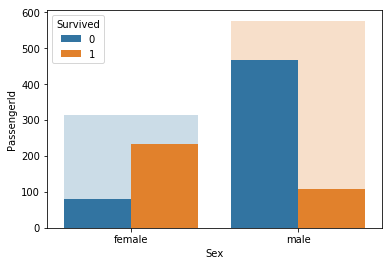

In [7]:
def barplot_survived(train, ftr):
    gr = train.groupby([ftr,'Survived']).PassengerId.count().reset_index()
    gr_total = train.groupby(ftr).PassengerId.count().reset_index()
    sns.barplot(data = gr_total, x = ftr, y = 'PassengerId',alpha = .25)
    sns.barplot(data = gr,x = ftr,y = 'PassengerId', hue = 'Survived')
barplot_survived(train,'Sex')

In [8]:
#transforming Sex into digital values
train['Sex'] = train.Sex.apply(lambda x: 1 if x=='male' else 0)
test['Sex'] = test.Sex.apply(lambda x: 1 if x=='male' else 0)

## Cabin type
I will use first letter as a cabin type

In [9]:
print_na(train, test, 'Cabin')

Amount of NaN values in train: 687 (77.1%)
Amount of NaN values in test: 327 (78.2%)


In [10]:
train.Cabin.dropna().head(10)

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object

In [11]:
#Cabin type fill
def cabin_type(x):
    try:
        return x[0]
    except:
        return 'unknown'
train['Cabin'] = train.Cabin.apply(cabin_type)
test['Cabin'] = test.Cabin.apply(cabin_type)


In [12]:
#na fill
train['Cabin'] = train.Cabin.fillna('unknown')
test['Cabin'] = train.Cabin.fillna('unknown')

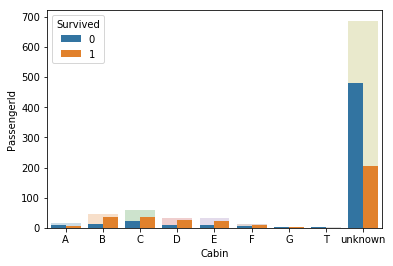

In [13]:
barplot_survived(train,'Cabin')

## Ticket type

In [14]:
print_na(train,test,'Ticket')

Amount of NaN values in train: 0 (0.0%)
Amount of NaN values in test: 0 (0.0%)


In [15]:
train.Ticket.dropna().head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [16]:
def ticket_type(x):
    try:
        ticket = int(x)
        return 'unknown'
    except:
        ticket = x.split(' ')[0].strip().lower()
        ticket_type = re.sub(r'[\/\d\.\,]','',ticket)
        if ticket_type in ['pc','ca','a']:
            return ticket_type
        else:
            return 'unknown'
train['TicketType'] = train.Ticket.apply(ticket_type)
test['TicketType'] = test.Ticket.apply(ticket_type)

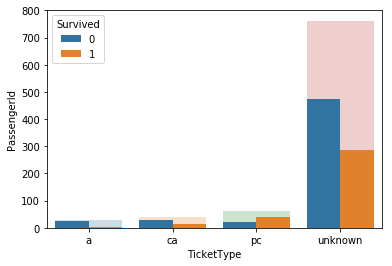

In [17]:
barplot_survived(train,'TicketType')

## Embarked

In [18]:
print_na(train,test,'Embarked')

Amount of NaN values in train: 2 (0.2%)
Amount of NaN values in test: 0 (0.0%)


In [19]:
train['Embarked'] = train.Embarked.fillna(train.Embarked.mode()[0])

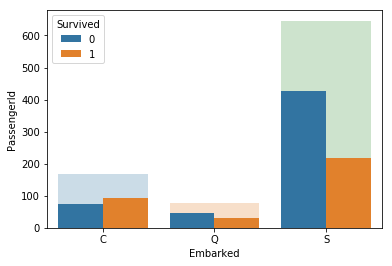

In [20]:
barplot_survived(train,'Embarked')

## PClass

In [21]:
print_na(train,test,'Pclass')

Amount of NaN values in train: 0 (0.0%)
Amount of NaN values in test: 0 (0.0%)


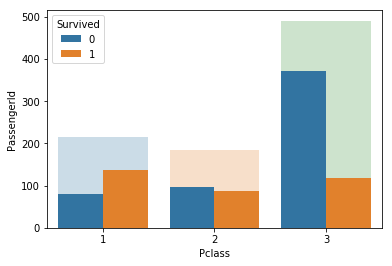

In [22]:
barplot_survived(train,'Pclass')

## Age

In [23]:
print_na(train,test,'Age')

Amount of NaN values in train: 177 (19.9%)
Amount of NaN values in test: 86 (20.6%)


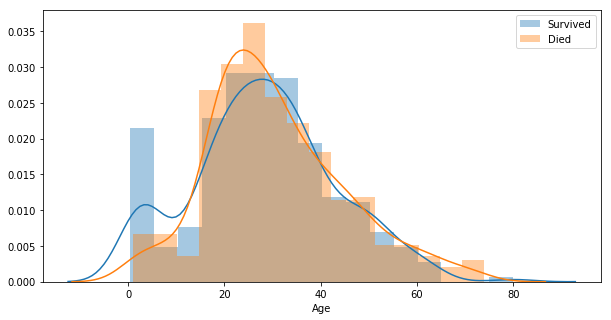

In [24]:
def distplot_survived(train, ftr):
    f,ax = plt.subplots(figsize = (10,5))
    sns.distplot(train[train.Survived==1][ftr].dropna(),ax= ax, label = 'Survived')
    sns.distplot(train[train.Survived==0][ftr].dropna(),ax= ax, label = 'Died')
    ax.legend()
distplot_survived(train,'Age')

In [25]:
train[train.Survived==1].Age.mode()[0]

24.0

In [26]:
print("Mode for survived: {0}, Average for survived: {1:.1f}".format(train[train.Survived==1].Age.mode()[0],
                                                                 train[train.Survived==1].Age.mean()))
print("Mode for died: {0}, Average for died: {1:.1f}".format(train[train.Survived==0].Age.mode()[0],
                                                    train[train.Survived==0].Age.mean()))
print("Mode for all train: {0}, Average for all train: {1:.1f}".format(train.Age.mode()[0],
                                                    train.Age.mean()))


Mode for survived: 24.0, Average for survived: 28.3
Mode for died: 21.0, Average for died: 30.6
Mode for all train: 24.0, Average for all train: 29.7


In [27]:
train['Age'] = train.Age.fillna(train.Age.mode()[0])
test['Age'] = test.Age.fillna(test.Age.mode()[0])

## Fare

In [28]:
print_na(train,test,'Fare')

Amount of NaN values in train: 0 (0.0%)
Amount of NaN values in test: 1 (0.2%)


In [29]:
test['Fare'] = test.Fare.fillna(test.Fare.mode()[0])

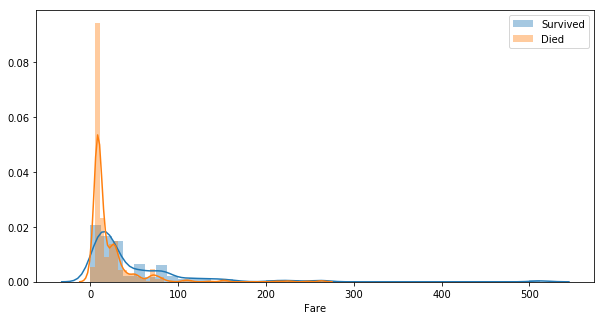

In [30]:
distplot_survived(train,'Fare')

In [31]:
print('Mean fare: {0:.1f}, mode fare: {1}'.format(train.Fare.mean(),
                                             train.Fare.mode()[0]))

Mean fare: 32.2, mode fare: 8.05


## SibSp

In [32]:
print_na(train,test,'SibSp')

Amount of NaN values in train: 0 (0.0%)
Amount of NaN values in test: 0 (0.0%)


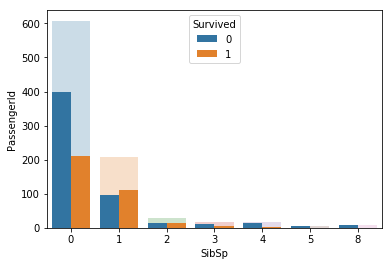

In [33]:
barplot_survived(train,'SibSp')

## Parch

In [34]:
print_na(train,test,'Parch')

Amount of NaN values in train: 0 (0.0%)
Amount of NaN values in test: 0 (0.0%)


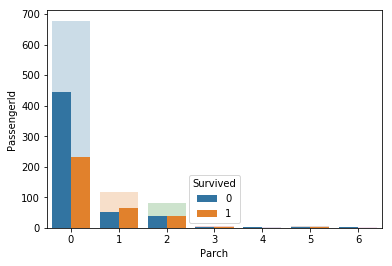

In [35]:
barplot_survived(train,'Parch')

## Summary for numerical features

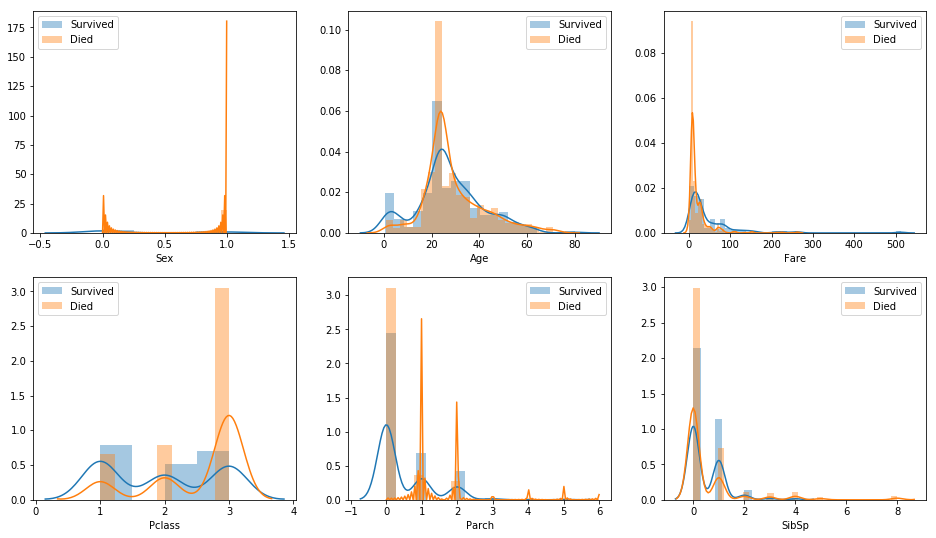

In [36]:
f, axs = plt.subplots(2,3,figsize = (16,9))
index = 0
for ftr in ['Sex','Age','Fare','Pclass','Parch','SibSp']:    
    ax = axs[index//3,index%3]
    sns.distplot(train[train.Survived==1][ftr].dropna(),ax= ax, label = 'Survived')
    sns.distplot(train[train.Survived==0][ftr].dropna(),ax= ax, label = 'Died')
    ax.legend()
    index +=1

So, we can see that women have more chance to survive. Among survived was a lot of kids or passengers of unknown age, so I think that age is not the most important factor. There are more survived people with high price tickets. Passengers of the 3rd class often die. Passengers without parent or kids on Titanic have more chance to alive. And if a passenger has 1 spouse or sibling he has more chance.

So, a married woman (or with 1 sibling) without kids from 1 or 2 class with high price ticket has the highest chance to survive on Titanic.

But we can not say that this is only one category of survived people, so I will continue to work with data.

## Married with spouse onboard?
I will suppose that a woman is married and traveled with her husband if she has status Mrs. and SibSp>=1
I will suppose that a man is married and traveled with his wife if he has SibSp>=1 and there is the woman with his last name and status Mrs.

In [37]:
#last name selection
train['LastName'] = train.Name.apply(lambda x: x.split(',')[0].lower().strip())
test['LastName'] = test.Name.apply(lambda x: x.split(',')[0].lower().strip())

In [38]:
#status selection
train['Status'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].lower().strip())
test['Status'] = test.Name.apply(lambda x: x.split(',')[1].split('.')[0].lower().strip())

In [39]:
def married(df):
    try:
        c = lastname[df['LastName']]['mrs']
    except:
        c = 0
    if df['Sex']==0  and df['Status']=='mrs' and df['SibSp']>=1:
        return 1
    elif df['Sex']==1 and df['SibSp']>=1 and c>=1:
        return 1
    else:
        return 0


In [40]:
def status_update(df):
    if df['Status'] in ['mr','miss','mrs','master']:
        return df['Status']
    elif df['Sex']==1:
        return 'mr'
    else:
        return 'miss'
train['Status'] = train.apply(status_update, axis = 1)
test['Status'] = test.apply(status_update, axis = 1)

In [41]:
lastname = train.groupby(['LastName','Status'])['PassengerId'].count()
train['Married'] = train.apply(married, axis = 1)
lastname = test.groupby(['LastName','Status'])['PassengerId'].count()
test['Married'] = test.apply(married, axis = 1)

## Name Length

In [42]:
train['NameLength'] = train.Name.apply(lambda x: len(x))
test['NameLength'] = test.Name.apply(lambda x:len(x))

## dummies for categories

In [43]:
features = ['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Cabin', 'Embarked', 'TicketType', 'Married','Status','NameLength']
y = train.Survived
X_train_ftr = pd.get_dummies(train[features])
X_test_ftr = pd.get_dummies(test[features])
#X_train_ftr.index = train.PassengerId
#X_test_ftr.index = test.PassengerId


## Correlation matrix

In [44]:
train.Married.value_counts()

0    736
1    155
Name: Married, dtype: int64

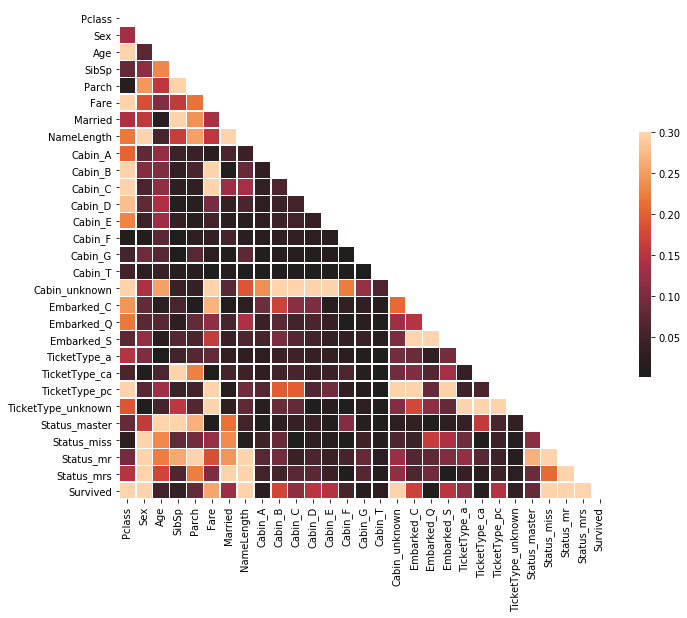

In [45]:
corr = pd.concat((X_train_ftr,y),axis = 1).corr()

mask = np.zeros_like(np.abs(corr), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(np.abs(corr), mask=mask,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

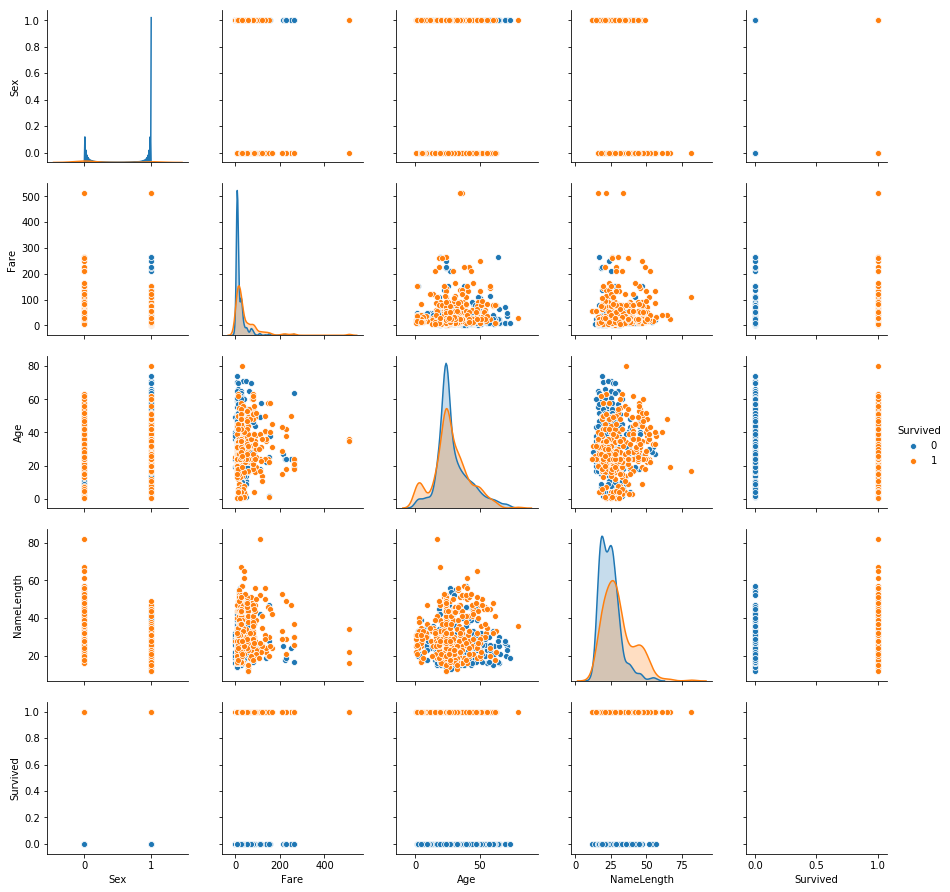

In [46]:
sns.pairplot(pd.concat((X_train_ftr[['Sex','Fare','Age','NameLength']],y),axis = 1), hue = 'Survived')

In [47]:
ftr_list = ['Pclass','Sex','Fare','Married','Cabin_unknown']

# Modeling

## Cross validation strategy

In [48]:
from sklearn.model_selection import cross_val_score,KFold

def scoring(clf, X, y):
    kf = KFold(5, shuffle=True, random_state=19).get_n_splits(X)
    cvs = cross_val_score(clf, X, y, cv=kf,scoring='accuracy')
    return cvs

## Feature selection
Removing features with low variance¶

In [49]:
from sklearn.feature_selection import VarianceThreshold

In [50]:
all_data = pd.concat((X_train_ftr,X_test_ftr))
selected  = VarianceThreshold(threshold=(.8 * (1 - .8))).fit_transform(all_data)
X_train_sel = selected[0:len(train)]
X_test_sel = selected[len(train):]

## Scaling

In [51]:
#X_train = RobustScaler(quantile_range=(10,90)).fit_transform(X_train_ftr)
#X_test = RobustScaler(quantile_range=(10,90)).fit_transform(X_test_ftr)

### SVM

In [52]:
from sklearn import svm

In [53]:
'''kf = KFold(5, shuffle=True, random_state=19).get_n_splits(X_train_sel)
svc = GridSearchCV(svm.SVC(random_state = 42), cv = kf,
                   param_grid = {
                       'kernel' : ['linear'],
                       'C': [100],
                   })
'''

"kf = KFold(5, shuffle=True, random_state=19).get_n_splits(X_train_sel)\nsvc = GridSearchCV(svm.SVC(random_state = 42), cv = kf,\n                   param_grid = {\n                       'kernel' : ['linear'],\n                       'C': [100],\n                   })\n"

In [54]:
svc = svm.SVC(random_state = 42, kernel = 'linear')

In [55]:
#svc.fit(X_train_sel,y)

In [56]:
#svc.best_estimator_

In [57]:
scr = scoring(svc, X_train_sel, y)

In [58]:
print('Mean: {0:.4f}, std: {1:.4f}'.format(scr.mean(),scr.std()))

Mean: 0.8261, std: 0.0258


In [59]:
svc.fit(X_train_sel,y)
prediction = svc.predict(X_test_sel)
res = pd.DataFrame()
res['PassengerId'] = test.PassengerId
res['Survived'] = prediction
res['Survived'] = res.Survived.astype(int)
res.to_csv('submission.csv', index = False)